#Advanced Data Analysis Project
##Elon musk quotes and Tesla stock price 



In [ ]:
import json 
import bz2
import csv 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pandas_datareader as web 
import re, string
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from scipy.stats import ttest_ind

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
#pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import sys
#sys.path.append('/content/drive/MyDrive/ADA_helpers')

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

##Part 1: Load the dataset:

We want to access the Quotebank data present in a Google Drive. To do so, we create two lists, the first one `path_to_file` containing the paths of the files to read and the second one `path_to_out` contains the paths of the new files that we will write. 

In [ ]:
path_to_file = [ '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2', 
                 '/content/drive/MyDrive/Quotebank/quotes-2019.json.bz2',
                 '/content/drive/MyDrive/Quotebank/quotes-2018.json.bz2',
                 '/content/drive/MyDrive/Quotebank/quotes-2017.json.bz2',
                 '/content/drive/MyDrive/Quotebank/quotes-2016.json.bz2',
                 '/content/drive/MyDrive/Quotebank/quotes-2015.json.bz2',
]
path_to_out = ['/content/drive/MyDrive/2020-ElonMusk.json.bz2',
               '/content/drive/MyDrive/2019-ElonMusk.json.bz2',
               '/content/drive/MyDrive/2018-ElonMusk.json.bz2',
               '/content/drive/MyDrive/2017-ElonMusk.json.bz2',
               '/content/drive/MyDrive/2016-ElonMusk.json.bz2',
               '/content/drive/MyDrive/2015-ElonMusk.json.bz2']


We first load and read all the QuoteBank data. Each quote has a speaker, and we are interested in all quotes coming from Elon Musk from 2015 to 2020. So from the QuoteBank data, we apply this first selection : each time a quote's speaker is Elon Musk, we write this quote on a new file. (this cell should only be run once to obtain our data)

In [ ]:
#I comment it so we can use the run all cells feature 
#to decomment when we submit 
'''for path_to, path_out in zip(path_to_file,path_to_out):
  with bz2.open(path_to, 'rb') as s_file:
  with bz2.open(path_out, 'wb') as d_file:
      for instance in s_file:
          instance = json.loads(instance) # loading a sample
          if instance['speaker'] == 'Elon Musk':
              d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file
'''

"for path_to, path_out in zip(path_to_file,path_to_out):\n  with bz2.open(path_to, 'rb') as s_file:\n  with bz2.open(path_out, 'wb') as d_file:\n      for instance in s_file:\n          instance = json.loads(instance) # loading a sample\n          if instance['speaker'] == 'Elon Musk':\n              d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file\n"

## Part 2 : 



From Part 1, we obtained 6 json files containing all Elon Musk quotes. The first thing to do now is to create a DataFrame that contains all this data, and we use the same list `path_to_out` that contains the paths of the new files obtained previously. So we read the json files and create `df_musk` DataFrame in which we concatenate all the data from 2015 to 2020.

In [ ]:
df_musk = pd.concat((pd.read_json(file, lines = True) for file in path_to_out),ignore_index=True)
df_musk.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E
1,2020-02-07-002094,A PhD is definitely not required. All that mat...,Elon Musk,[Q317521],2020-02-07 00:00:00,1,"[[Elon Musk, 0.9278], [None, 0.0722]]",[https://www.teslarati.com/tesla-ai-autopilot-...,E
2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E
3,2020-03-09-007954,But I'd like to at least be around to see a bu...,Elon Musk,[Q317521],2020-03-09 20:30:24,2,"[[Elon Musk, 0.9132], [None, 0.0868]]",[https://www.cnbc.com/2020/03/09/spacex-plans-...,E
4,2020-03-09-078624,will not cause any impact whatsoever in astron...,Elon Musk,[Q317521],2020-03-09 17:58:09,11,"[[Elon Musk, 0.815], [None, 0.1833], [Gwynne S...",[http://www.breitbart.com/news/elon-musk-dismi...,E


**Some sanity checks**

We have to check that all the quotes we have are from Elon Musk, we remove all duplicates from the data and we can plot the distribution of the quotes he made over time.

In [ ]:
other_speaker = len(df_musk[df_musk['speaker'] != 'Elon Musk'])
print ("There are {} quotes with a speaker who isn't Elon Musk".format(other_speaker))

There are 0 quotes with a speaker who isn't Elon Musk


Now we need to check for duplicate rows based on `quotation` column

In [ ]:
duplicate = len(df_musk[df_musk.duplicated('quotation')])
print ("There are {} quotes duplicated".format(duplicate))

There are 0 quotes duplicated


Let's look for the distribution of Elon Musk quotes along time. In our DataFrame `df_musk`, we have the column `date` that contains both the date and hour of the quotation, so we create a new column `just_date` in which we conserve only the date. Then, we groupby this new column and count how many quotes have been said this day and finally plot the distribution of these occurences versus time.

Text(0.5, 1.0, 'Number of Elon Musk quotes per day')

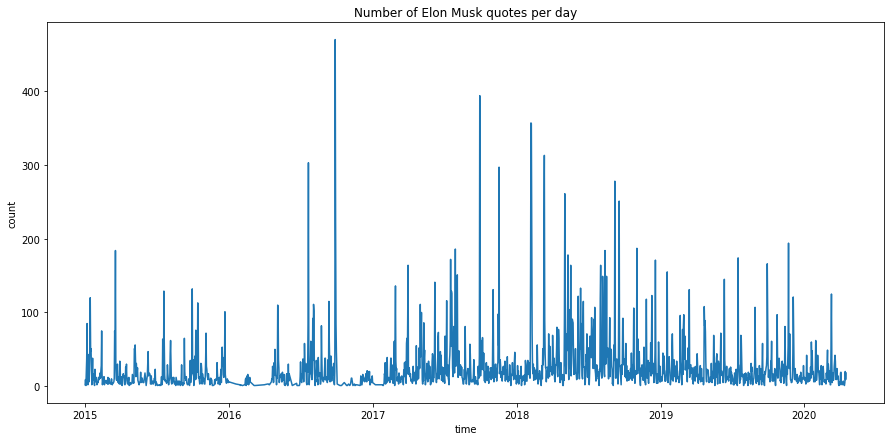

In [ ]:
df_musk['just_date'] = df_musk['date'].dt.date
fig,ax = plt.subplots(figsize =(15,7))
df_musk.groupby(by='just_date').count()['quotation'].plot(ax=ax)
ax.set_xlabel('time')
ax.set_ylabel('count')
ax.set_title('Number of Elon Musk quotes per day')

***We select from our dataframe all the quotes that contains the key world tesla and others in order to create a new data frame with these quotes***

In [ ]:
df_musk['selected_quotes'] = False
is_tesla = df_musk.quotation.str.contains("Tesla")
df_musk['selected_quotes'] = is_tesla
df_tesla_2 = df_musk[df_musk['selected_quotes'] == True]

In [ ]:
key_word = ['Tesla','car ','vehicle','tesla','Car ','Vehicle']
quote = 'I have a car'

def filter_quotes(row):
  return any(word in row['quotation'] for word in key_word)

r = df_musk.loc[1]

print(filter_quotes(r))
df_musk["selected_quotes"] = df_musk.apply(lambda x: filter_quotes(x),axis=1)
df_tesla_3 = df_musk[df_musk['selected_quotes'] == True]

False


In [ ]:
df_tesla_3

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,just_date,selected_quotes
0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E,2020-03-24,True
2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E,2020-03-24,True
5,2020-01-29-004715,"Also, you can request any service from the Tes...",Elon Musk,[Q317521],2020-01-29 00:00:00,1,"[[Elon Musk, 0.7879], [None, 0.2121]]",[https://www.teslarati.com/tesla-mobile-servic...,E,2020-01-29,True
9,2020-02-17-057451,Tesla's innovation strategy -- which focuses o...,Elon Musk,[Q317521],2020-02-17 00:00:00,1,"[[Elon Musk, 0.5602], [None, 0.4398]]",[http://www.techinsider.io/elon-musk-innovatio...,E,2020-02-17,True
12,2020-02-11-092528,"They simply want to guarantee a steady, truste...",Elon Musk,[Q317521],2020-02-11 10:00:00,3,"[[Elon Musk, 0.5501], [None, 0.4499]]",[https://www.proactiveinvestors.com/companies/...,E,2020-02-11,True
...,...,...,...,...,...,...,...,...,...,...,...
43558,2015-10-03-030805,It's important to show that any type of vehicl...,Elon Musk,[Q317521],2015-10-03 16:01:00,1,"[[Elon Musk, 0.9678], [None, 0.0322]]",[http://www.autoblog.com/2015/10/03/weekly-rec...,E,2015-10-03,True
43569,2015-12-14-000484,' Tesla graveyard.' If you don't make it at Te...,Elon Musk,[Q317521],2015-12-14 22:52:19,1,"[[Elon Musk, 0.8681], [None, 0.1011], [Bill Ma...",[http://techcrunch.com/gallery/the-7-best-tech...,E,2015-12-14,True
43580,2015-11-28-026077,If they do somehow show up in the next five ye...,Elon Musk,[Q317521],2015-11-28 23:00:42,1,"[[Elon Musk, 0.9552], [None, 0.0433], [Jeff Be...",[http://scmp.com/news/article/1884733/shooting...,E,2015-11-28,True
43582,2015-08-11-048747,is a way for us to sort have a guerrilla battl...,Elon Musk,[Q317521],2015-08-11 20:45:51,6,"[[Elon Musk, 0.9434], [None, 0.0566]]",[http://feeds.businessinsider.com.au/~/1060872...,E,2015-08-11,True


In [ ]:
filtered_indexes = []
key_word = ['tesla','car','vehicle']
length = len(df_musk.quotation)
for k in range(len(key_word)):
  for i in range (length):
    quote = df_musk.iloc[i]['quotation']
    if key_word[k] in quote.lower():
        filtered_indexes.append(i)

print(len(filtered_indexes))
df_tesla = df_musk.iloc[filtered_indexes] #creates a dataframe with all the quotes containing our keywords

9750


Text(0.5, 1.0, 'Number of Elon Musk quotes about tesla per day')

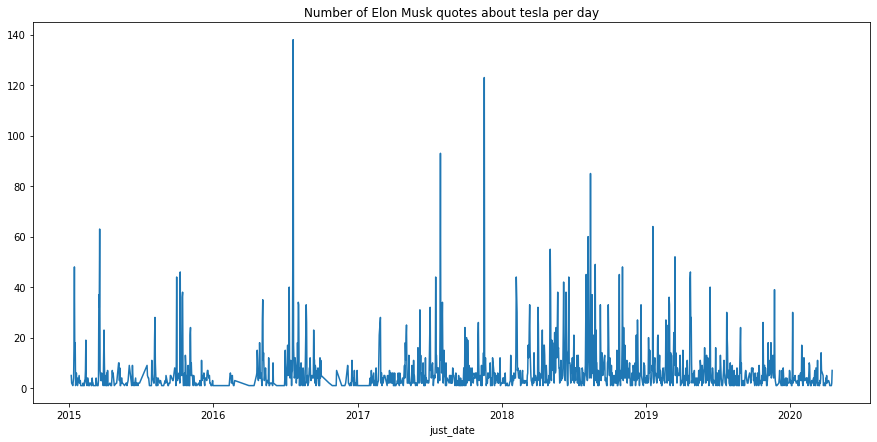

In [ ]:
fig,ax = plt.subplots(figsize =(15,7))
df_tesla.groupby(by='just_date').count()['quotation'].plot(ax=ax)
ax.set_title('Number of Elon Musk quotes about tesla per day')

##***1. Importing tesla stock price from Yahoo Finance***

In this part, we will load from Yahoo Finance an additional dataset containing the most important features of Tesla stock market like the open and close prices or the volume. We also need to specify the start and end date to load this dataset and we select them based on the date of the first and last quote of `df_musk` dataframe.

In [ ]:
print('the first quote was said on :',df_musk.sort_values(by = 'just_date').head(1).just_date.values, 
      'and the last quote was said on:', df_musk.sort_values(by = 'just_date').tail(1).just_date.values)


the first quote was said on : [datetime.date(2015, 1, 1)] and the last quote was said on: [datetime.date(2020, 4, 16)]


In [ ]:
tesla = web.get_data_yahoo("TSLA",
                            start = "2015-01-01",
                            end = "2020-04-16")
tesla.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,44.650002,42.652000,44.574001,43.862000,23822000,43.862000
2015-01-05,43.299999,41.431999,42.910000,42.018002,26842500,42.018002
2015-01-06,42.840000,40.841999,42.012001,42.256001,31309500,42.256001
2015-01-07,42.956001,41.956001,42.669998,42.189999,14842000,42.189999
2015-01-08,42.759998,42.001999,42.562000,42.124001,17212500,42.124001


For a vizualisation purpose, we can plot the evolution of Tesla stock price over time. We can see how the stock price grows over time, and more specially in 2020


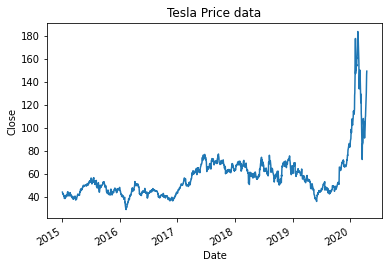

In [ ]:
tesla['Close'].plot()
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Tesla Price data")
plt.show()

The next step we need to perform is to calculate and to plot the daily returns of Tesla stock price, which corresponds to the change in price of the stock price between the previous day and the current one. This is done using the pct_change function that will calculate the change between the previous value and the current one, which will espress the returns in percent. We apply this function on the `Close` column of tesla DataFrame because we're interested in the last price at which the stock traded during the day.

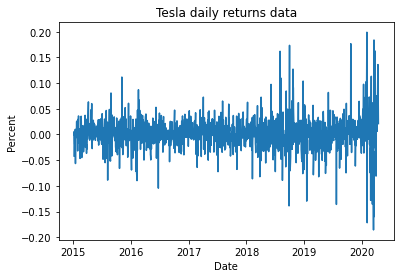

In [ ]:
tesla['returns'] = tesla['Close'].pct_change()
tesla.head()
plt.plot(tesla.returns)
plt.xlabel("Date")
plt.ylabel("Percent")
plt.title("Tesla daily returns data")
plt.show()

Using a histogram, we can visualize the distribution of the returns and to see how extreme can the returns be. In this case, we can see that the returns go from -0.2 to 0.2 which is ...

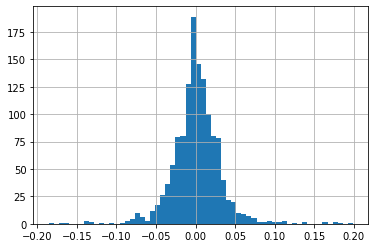

In [ ]:
#to get a sense of how extreme the returns can be we can plot a histogram.
tesla.returns.hist(bins=60)

[Text(0.5, 1.0, 'Tesla stock price returns')]

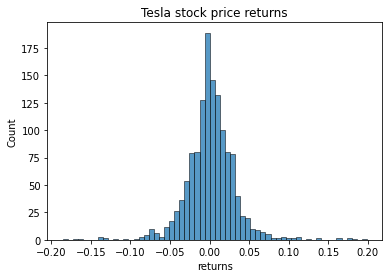

In [ ]:
sns.histplot(data=tesla, x="returns",bins=60).set(title='Tesla stock price returns')

**Create a dataframe for returns:**

Here we create a dataframe that will be used later for our prediction, it contains the return with its corresponding date. Because the returns compare the previous row with the current one, the return in the first row of the dataframe is nan, and we will drop it using dropna function.


In [ ]:
tesla = tesla.reset_index()
tesla.rename(columns = {'Date': 'just_date'}, inplace = True)
df_returns = tesla[['just_date','returns']].dropna()
df_returns

,just_date,returns
1,2015-01-05,-0.042041
2,2015-01-06,0.005664
3,2015-01-07,-0.001562
4,2015-01-08,-0.001564
5,2015-01-09,-0.018802
...,...,...
1326,2020-04-09,0.044020
1327,2020-04-13,0.136038
1328,2020-04-14,0.090545
1329,2020-04-15,0.028089


##Part 3 : Quotations preprocessing

We start by preprocessing the quotation to explore them. In instance, we can use to find the most 10 common words, **STILL NEED TO BE COMPLETED**

**Cleaning the quotations**
 
This function will prepare the quotations so that we can use them afterwards to perform analysis, basically it will do the following: 


*   Transform to lower case, remove all that is not words or numbers.  
*   Tokenization meaning breaking up every quotation into a group of indivudual words.
*   Remove stopwords which does not add much information to the quotations. 



**First Step : We remove punctuation**

We create a function that will remove punctuation using the string library which contains a predefined list of punctuation.



In [ ]:
import string
print ("We remove all the punctuation that follows from our quotation {}".format(string.punctuation))

We remove all the punctuation that follows from our quotation !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Each time we find one of the punctuation listed above, the function remove_punctuation takes it off. We then apply this fuction to each quote of `df_musk` DataFrame and store this new quote in a new column `removed_punctuation`.

In [ ]:
def remove_punctuation(quote):
    no_punctuation ="".join([i for i in quote if i not in string.punctuation])
    return no_punctuation

df_musk['removed_punctuation']= df_musk['quotation'].apply(lambda x:remove_punctuation(x))
df_musk.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,just_date,selected_quotes,removed_punctuation
0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E,2020-03-24,True,We are grateful for the discussion with ElonMu...
1,2020-02-07-002094,A PhD is definitely not required. All that mat...,Elon Musk,[Q317521],2020-02-07 00:00:00,1,"[[Elon Musk, 0.9278], [None, 0.0722]]",[https://www.teslarati.com/tesla-ai-autopilot-...,E,2020-02-07,False,A PhD is definitely not required All that matt...
2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E,2020-03-24,True,addressing COVID19 is a group effort We are gr...
3,2020-03-09-007954,But I'd like to at least be around to see a bu...,Elon Musk,[Q317521],2020-03-09 20:30:24,2,"[[Elon Musk, 0.9132], [None, 0.0868]]",[https://www.cnbc.com/2020/03/09/spacex-plans-...,E,2020-03-09,False,But Id like to at least be around to see a bun...
4,2020-03-09-078624,will not cause any impact whatsoever in astron...,Elon Musk,[Q317521],2020-03-09 17:58:09,11,"[[Elon Musk, 0.815], [None, 0.1833], [Gwynne S...",[http://www.breitbart.com/news/elon-musk-dismi...,E,2020-03-09,False,will not cause any impact whatsoever in astron...


**Second Step : Casefolding** 

Because our dataset is quite small, we decided to first lower all the quotes to reduce the sparsity of the data. To do so, we apply on the `removed_punctuation` column the function .lower() from Python that returns lowercased strings

In [ ]:
df_musk['casefold']= df_musk['removed_punctuation'].apply(lambda x: x.lower())
df_musk.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,just_date,selected_quotes,removed_punctuation,casefold
0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E,2020-03-24,True,We are grateful for the discussion with ElonMu...,we are grateful for the discussion with elonmu...
1,2020-02-07-002094,A PhD is definitely not required. All that mat...,Elon Musk,[Q317521],2020-02-07 00:00:00,1,"[[Elon Musk, 0.9278], [None, 0.0722]]",[https://www.teslarati.com/tesla-ai-autopilot-...,E,2020-02-07,False,A PhD is definitely not required All that matt...,a phd is definitely not required all that matt...
2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E,2020-03-24,True,addressing COVID19 is a group effort We are gr...,addressing covid19 is a group effort we are gr...
3,2020-03-09-007954,But I'd like to at least be around to see a bu...,Elon Musk,[Q317521],2020-03-09 20:30:24,2,"[[Elon Musk, 0.9132], [None, 0.0868]]",[https://www.cnbc.com/2020/03/09/spacex-plans-...,E,2020-03-09,False,But Id like to at least be around to see a bun...,but id like to at least be around to see a bun...
4,2020-03-09-078624,will not cause any impact whatsoever in astron...,Elon Musk,[Q317521],2020-03-09 17:58:09,11,"[[Elon Musk, 0.815], [None, 0.1833], [Gwynne S...",[http://www.breitbart.com/news/elon-musk-dismi...,E,2020-03-09,False,will not cause any impact whatsoever in astron...,will not cause any impact whatsoever in astron...


**Third Step : Tokenization**

One use of this step is to determine the 10 most common words of Elon Musk quotes. To do so, we now use the function word_tokenize from NLTK library, we apply it to the column `casefold` and store the output in a new column `tokenize_quote`. 


In [ ]:
df_musk['tokenize_quote'] = df_musk['casefold'].apply(lambda x: word_tokenize(x))
df_musk.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,just_date,selected_quotes,removed_punctuation,casefold,tokenize_quote
0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E,2020-03-24,True,We are grateful for the discussion with ElonMu...,we are grateful for the discussion with elonmu...,"[we, are, grateful, for, the, discussion, with..."
1,2020-02-07-002094,A PhD is definitely not required. All that mat...,Elon Musk,[Q317521],2020-02-07 00:00:00,1,"[[Elon Musk, 0.9278], [None, 0.0722]]",[https://www.teslarati.com/tesla-ai-autopilot-...,E,2020-02-07,False,A PhD is definitely not required All that matt...,a phd is definitely not required all that matt...,"[a, phd, is, definitely, not, required, all, t..."
2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E,2020-03-24,True,addressing COVID19 is a group effort We are gr...,addressing covid19 is a group effort we are gr...,"[addressing, covid19, is, a, group, effort, we..."
3,2020-03-09-007954,But I'd like to at least be around to see a bu...,Elon Musk,[Q317521],2020-03-09 20:30:24,2,"[[Elon Musk, 0.9132], [None, 0.0868]]",[https://www.cnbc.com/2020/03/09/spacex-plans-...,E,2020-03-09,False,But Id like to at least be around to see a bun...,but id like to at least be around to see a bun...,"[but, id, like, to, at, least, be, around, to,..."
4,2020-03-09-078624,will not cause any impact whatsoever in astron...,Elon Musk,[Q317521],2020-03-09 17:58:09,11,"[[Elon Musk, 0.815], [None, 0.1833], [Gwynne S...",[http://www.breitbart.com/news/elon-musk-dismi...,E,2020-03-09,False,will not cause any impact whatsoever in astron...,will not cause any impact whatsoever in astron...,"[will, not, cause, any, impact, whatsoever, in..."


**Forth Step : Remove stop words**

We have to remove all the stop words that don't provide any further information to our analysis. To do so, we use a pre-existing list of stop words that we download from nltk library and we specify the language we need, ie english. Then, we crate the function remove_sw that will for each quote output all the words that are not present in the stopwords list. We can then apply this function on our dataframe and store this new step into a new column `remove_sw`.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
sw = stopwords.words('english')
def remove_sw(quote):
  quote_no_sw = [word for word in quote if not word in sw]
  return quote_no_sw 
df_musk['remove_sw'] = df_musk['tokenize_quote'].apply(lambda x: remove_sw(x))
df_musk.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,just_date,selected_quotes,removed_punctuation,casefold,tokenize_quote,remove_sw
0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E,2020-03-24,True,We are grateful for the discussion with ElonMu...,we are grateful for the discussion with elonmu...,"[we, are, grateful, for, the, discussion, with...","[grateful, discussion, elonmusk, tesla, work, ..."
1,2020-02-07-002094,A PhD is definitely not required. All that mat...,Elon Musk,[Q317521],2020-02-07 00:00:00,1,"[[Elon Musk, 0.9278], [None, 0.0722]]",[https://www.teslarati.com/tesla-ai-autopilot-...,E,2020-02-07,False,A PhD is definitely not required All that matt...,a phd is definitely not required all that matt...,"[a, phd, is, definitely, not, required, all, t...","[phd, definitely, required, matters, deep, und..."
2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E,2020-03-24,True,addressing COVID19 is a group effort We are gr...,addressing covid19 is a group effort we are gr...,"[addressing, covid19, is, a, group, effort, we...","[addressing, covid19, group, effort, grateful,..."
3,2020-03-09-007954,But I'd like to at least be around to see a bu...,Elon Musk,[Q317521],2020-03-09 20:30:24,2,"[[Elon Musk, 0.9132], [None, 0.0868]]",[https://www.cnbc.com/2020/03/09/spacex-plans-...,E,2020-03-09,False,But Id like to at least be around to see a bun...,but id like to at least be around to see a bun...,"[but, id, like, to, at, least, be, around, to,...","[id, like, least, around, see, bunch, ships, l..."
4,2020-03-09-078624,will not cause any impact whatsoever in astron...,Elon Musk,[Q317521],2020-03-09 17:58:09,11,"[[Elon Musk, 0.815], [None, 0.1833], [Gwynne S...",[http://www.breitbart.com/news/elon-musk-dismi...,E,2020-03-09,False,will not cause any impact whatsoever in astron...,will not cause any impact whatsoever in astron...,"[will, not, cause, any, impact, whatsoever, in...","[cause, impact, whatsoever, astronomical, disc..."


**Fifth Step : Lemmatization**

Finally, we need to map different form of words into a single form. To do so, one can either choose stemming or lemmatization, however, this last one is more meaningful because it uses the word context instead of just the word radical, so it gives more accurate mapping. We create a function that uses the existing WordNetLemmatizer from the nltk library, and returns a lemmatized version of the words we had in each quote. Again, we store this return in the new column `lemmatized_quote`.

In [ ]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
def lemmatize_quotation(quotation):
  lemm_quotation = [wordnet_lemmatizer.lemmatize(word) for word in quotation]
  return lemm_quotation

df_musk['lemmatized_quote']= df_musk['remove_sw'].apply(lambda x: lemmatize_quotation(x))
df_musk.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,just_date,selected_quotes,removed_punctuation,casefold,tokenize_quote,remove_sw,lemmatized_quote
0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E,2020-03-24,True,We are grateful for the discussion with ElonMu...,we are grateful for the discussion with elonmu...,"[we, are, grateful, for, the, discussion, with...","[grateful, discussion, elonmusk, tesla, work, ...","[grateful, discussion, elonmusk, tesla, work, ..."
1,2020-02-07-002094,A PhD is definitely not required. All that mat...,Elon Musk,[Q317521],2020-02-07 00:00:00,1,"[[Elon Musk, 0.9278], [None, 0.0722]]",[https://www.teslarati.com/tesla-ai-autopilot-...,E,2020-02-07,False,A PhD is definitely not required All that matt...,a phd is definitely not required all that matt...,"[a, phd, is, definitely, not, required, all, t...","[phd, definitely, required, matters, deep, und...","[phd, definitely, required, matter, deep, unde..."
2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E,2020-03-24,True,addressing COVID19 is a group effort We are gr...,addressing covid19 is a group effort we are gr...,"[addressing, covid19, is, a, group, effort, we...","[addressing, covid19, group, effort, grateful,...","[addressing, covid19, group, effort, grateful,..."
3,2020-03-09-007954,But I'd like to at least be around to see a bu...,Elon Musk,[Q317521],2020-03-09 20:30:24,2,"[[Elon Musk, 0.9132], [None, 0.0868]]",[https://www.cnbc.com/2020/03/09/spacex-plans-...,E,2020-03-09,False,But Id like to at least be around to see a bun...,but id like to at least be around to see a bun...,"[but, id, like, to, at, least, be, around, to,...","[id, like, least, around, see, bunch, ships, l...","[id, like, least, around, see, bunch, ship, la..."
4,2020-03-09-078624,will not cause any impact whatsoever in astron...,Elon Musk,[Q317521],2020-03-09 17:58:09,11,"[[Elon Musk, 0.815], [None, 0.1833], [Gwynne S...",[http://www.breitbart.com/news/elon-musk-dismi...,E,2020-03-09,False,will not cause any impact whatsoever in astron...,will not cause any impact whatsoever in astron...,"[will, not, cause, any, impact, whatsoever, in...","[cause, impact, whatsoever, astronomical, disc...","[cause, impact, whatsoever, astronomical, disc..."


##Part 4 most common words + filtering the dataframe

**Analyse Elon Musk's quotation:**

Here we decided to explore Elon Musk's quotations to get an insight of our data and to which extent we can use this data for our goal project. 
First we will find the most common words in order to determine what are the predominant topics of Elon Musk's quotations. 

The first thing to do is to put all the quotes in a single string `all_words_list`. Then, we calculate the frequency of each word in this string using the function FreqDist fron nltk library. Then from the output `freq` we create the DataFrame `freq_df` that will contain all the words of the quotation and their frequencies. We sort the column `Count` so that we have the most frequent words at the beggining of the DataFrame and we select the 20 first ones


In [ ]:
all_words = df_musk['lemmatized_quote'].tolist()
all_words_list = [item for sublist in all_words for item in sublist]
freq = nltk.FreqDist(all_words_list)
freq_df = pd.DataFrame({'Word': list(freq.keys()), 'Count': list(freq.values())}).sort_values(by=['Count'], ascending=False)
freq_df = freq_df.iloc[0:20,:]
freq_df

,Word,Count
3,tesla,4501
136,car,4417
161,think,3698
49,like,3551
352,would,2977
200,going,2948
77,people,2906
138,year,2714
460,model,2661
204,really,2458


We see that the 2 first words are Tesla and cars, which seems to be the proheminents topic et concorde avec notre hypothese de base qui met en avant l'interet d'elon musk vis a vis de Tesla et de l'industrie automobile entre autres.

Also, we can see that the step where we removed the stopwords wasn't totally efficient : the fact that we removed the punctuation first a fait qu'on a enleve l'apostrophe et que les mots comme don't qui deviennent alors dont ne sont pas supprimées. However, we do get the main topic of the quotes based on the two first most common word in all the quotes.

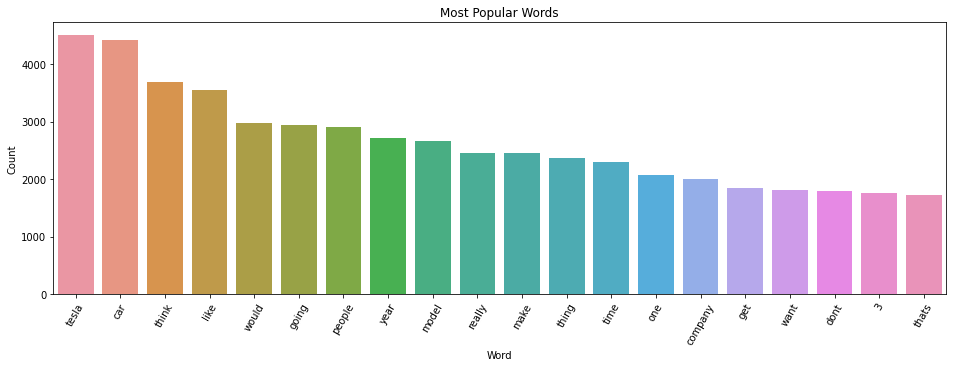

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.barplot(data=freq_df, x= "Word", y = "Count")
ax.set_ylabel('Count')
ax.set_xlabel('Word')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
ax.set_title("Most Popular Words")
plt.show()

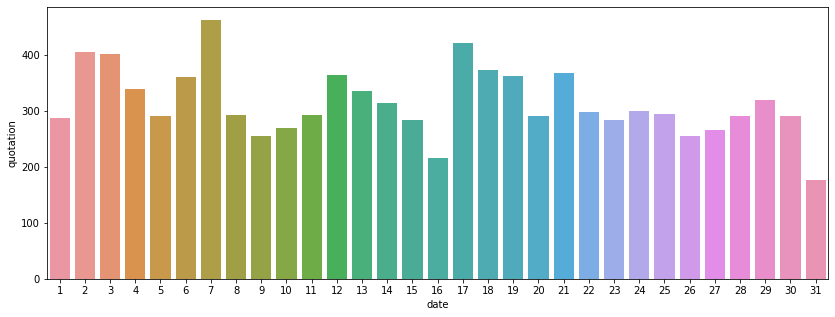

In [ ]:
df2 = pd.DataFrame(df_tesla.groupby(df_tesla['date'].dt.day)['quotation'].count()).reset_index()
plt.figure(figsize=(14,5))
ax = sns.barplot(data=df2, x= "date", y = "quotation")

Now that we have get the main dataset preprocessed, we can select from our dataframe all the quotes that contains some key words in order to create a more specific data frame with these quotes. The list of key words is selected based on the most common words obtained and the topic we're interested in.

In [ ]:
key_word = ['tesla','car','vehicle']
def filter_quotes(row):
  return any(word in row['lemmatized_quote'] for word in key_word)
df_musk["selected_quotes"] = df_musk.apply(lambda x: filter_quotes(x),axis=1)
df_tesla = df_musk[df_musk['selected_quotes'] == True]
df_tesla.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,just_date,selected_quotes,removed_punctuation,casefold,tokenize_quote,remove_sw,lemmatized_quote
0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E,2020-03-24,True,We are grateful for the discussion with ElonMu...,we are grateful for the discussion with elonmu...,"[we, are, grateful, for, the, discussion, with...","[grateful, discussion, elonmusk, tesla, work, ...","[grateful, discussion, elonmusk, tesla, work, ..."
2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E,2020-03-24,True,addressing COVID19 is a group effort We are gr...,addressing covid19 is a group effort we are gr...,"[addressing, covid19, is, a, group, effort, we...","[addressing, covid19, group, effort, grateful,...","[addressing, covid19, group, effort, grateful,..."
5,2020-01-29-004715,"Also, you can request any service from the Tes...",Elon Musk,[Q317521],2020-01-29 00:00:00,1,"[[Elon Musk, 0.7879], [None, 0.2121]]",[https://www.teslarati.com/tesla-mobile-servic...,E,2020-01-29,True,Also you can request any service from the Tesl...,also you can request any service from the tesl...,"[also, you, can, request, any, service, from, ...","[also, request, service, tesla, phone, app, mi...","[also, request, service, tesla, phone, app, mi..."
9,2020-02-17-057451,Tesla's innovation strategy -- which focuses o...,Elon Musk,[Q317521],2020-02-17 00:00:00,1,"[[Elon Musk, 0.5602], [None, 0.4398]]",[http://www.techinsider.io/elon-musk-innovatio...,E,2020-02-17,True,Teslas innovation strategy which focuses on t...,teslas innovation strategy which focuses on t...,"[teslas, innovation, strategy, which, focuses,...","[teslas, innovation, strategy, focuses, transf...","[tesla, innovation, strategy, focus, transform..."
12,2020-02-11-092528,"They simply want to guarantee a steady, truste...",Elon Musk,[Q317521],2020-02-11 10:00:00,3,"[[Elon Musk, 0.5501], [None, 0.4499]]",[https://www.proactiveinvestors.com/companies/...,E,2020-02-11,True,They simply want to guarantee a steady trusted...,they simply want to guarantee a steady trusted...,"[they, simply, want, to, guarantee, a, steady,...","[simply, want, guarantee, steady, trusted, sup...","[simply, want, guarantee, steady, trusted, sup..."


Text(0.5, 1.0, 'Number of Elon Musk quotes per day')

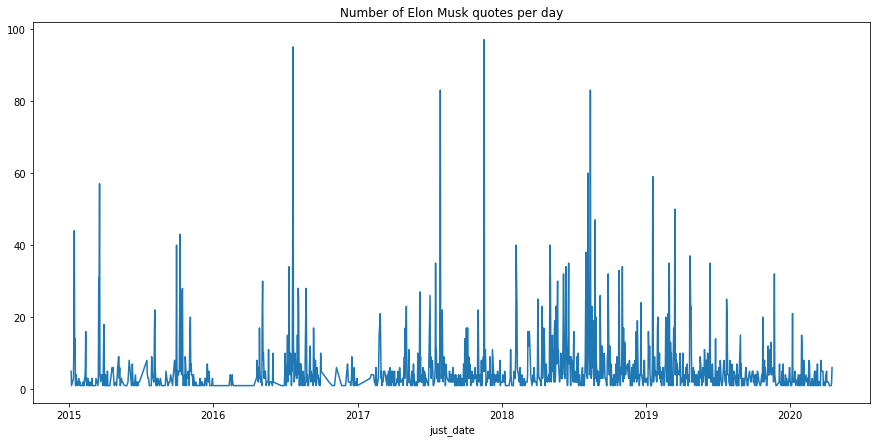

In [ ]:
fig,ax = plt.subplots(figsize =(15,7))
df_tesla.groupby(by='just_date').count()['quotation'].plot(ax=ax)
ax.set_title('Number of Elon Musk quotes per day') ### something is wrong here  

##Part 5: Sentiment analysis:

**Vader sentiment analysis :**

This model returns the compound score that informs if the quote is positive (compound>=0.05), neutral(-0.5>compound>0.05) or negative(compound >= -0.05). These conditions are grouped in the function decide_sentiment that will return for each quote the corresponding sentiment predicted. It also gives three other metrics, "pos, neu, and neg scores are ratios for proportions of text that fall in each category"(Github) https://github.com/cjhutto/vaderSentiment

Also, we apply these sentiment analyses on the quotation without any preprocessing. Indeed, the punctuation or the uppercase can be informative in our case to predict the sentiment of a quote.

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
df_sentiment_vader = df_tesla['quotation'].apply(lambda x: sid.polarity_scores(x).get('compound'))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
def decide_sentiment(x):
  if x >= 0.05 :
      return "positive"
  elif x <= - 0.05 :
      return "negative"
  else :
      return "neutral"

In [ ]:
def decide_sentiment(x):
  if x >= 0.05 :
      return 1
  elif x <= - 0.05 :
      return -1
  else :
      return 0

Below, we create a dataframe that will contain the output of the Vader Sentiment Analysis model, with a column for the categorical and the continuous return.

In [ ]:
df_sentiment = df_tesla[['just_date']].copy()
df_sentiment["vader_sentiment"] = df_sentiment_vader.apply(lambda x: decide_sentiment(x))
df_sentiment["vader_sentiment_continuous"] = df_sentiment_vader
df_sentiment

,just_date,vader_sentiment,vader_sentiment_continuous
0,2020-03-24,1,0.2732
2,2020-03-24,1,0.2732
5,2020-01-29,0,0.0000
9,2020-02-17,1,0.3818
12,2020-02-11,1,0.6597
...,...,...,...
43570,2015-10-11,1,0.2263
43580,2015-11-28,1,0.3400
43582,2015-08-11,-1,-0.3818
43589,2015-01-13,0,0.0000


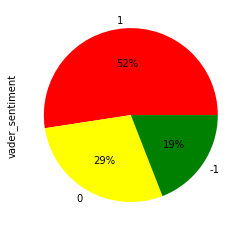

In [ ]:
df_sentiment.vader_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

**Textblob sentiment analysis**:

For the second model, we used TextBlob, another pretrained model to do the sentiment analysis. This model returns two values : the polarity (ie how much a quote is positive or negative) in a range between -1 and 1, and the subjectivity (ie how much the content of a quote is objective or not) in a range between 0 and 1. 

As before, we create the function decide_subjectivity that give a categorized return : either subjective if the subjectivity > 0,5, objective if subjectivity < 0,5 and neutral if the subjectivity = 0.5. Then, we can keep both categorized and continuous variables in `df_sentiment` dataframe for both the polarity and subjectivity.

In [ ]:
def decide_subjectivity(x):
  if x > 0.5:
      return "subjective"
  elif x < 0.5:
      return "objective"
  else :
      return "neutral"

In [ ]:
df_sentiment_blob = df_tesla['quotation'].apply(lambda x: TextBlob(x).sentiment)
df_sentiment["blob_sentiment"] = df_sentiment_blob.apply(lambda x: decide_sentiment(x.polarity))
df_sentiment["blob_sentiment_continuous"] = df_sentiment_blob.apply(lambda x: x.polarity)
df_sentiment

,just_date,vader_sentiment,vader_sentiment_continuous,blob_sentiment,blob_sentiment_continuous
0,2020-03-24,1,0.2732,0,0.000000
2,2020-03-24,1,0.2732,0,0.000000
5,2020-01-29,0,0.0000,0,0.000000
9,2020-02-17,1,0.3818,1,0.150000
12,2020-02-11,1,0.6597,1,0.188889
...,...,...,...,...,...
43570,2015-10-11,1,0.2263,1,0.150000
43580,2015-11-28,1,0.3400,1,0.166667
43582,2015-08-11,-1,-0.3818,0,0.000000
43589,2015-01-13,0,0.0000,-1,-0.200000


In [ ]:
df_sentiment["blob_subjectivity"] = df_sentiment_blob.apply(lambda x: decide_subjectivity(x.subjectivity))
df_sentiment["blob_subjectivity_continuous"] = df_sentiment_blob.apply(lambda x: x.subjectivity)
df_sentiment

,just_date,vader_sentiment,vader_sentiment_continuous,blob_sentiment,blob_sentiment_continuous,blob_subjectivity,blob_subjectivity_continuous
0,2020-03-24,1,0.2732,0,0.000000,objective,0.000000
2,2020-03-24,1,0.2732,0,0.000000,objective,0.000000
5,2020-01-29,0,0.0000,0,0.000000,objective,0.000000
9,2020-02-17,1,0.3818,1,0.150000,objective,0.200000
12,2020-02-11,1,0.6597,1,0.188889,objective,0.496825
...,...,...,...,...,...,...,...
43570,2015-10-11,1,0.2263,1,0.150000,subjective,0.800000
43580,2015-11-28,1,0.3400,1,0.166667,objective,0.366667
43582,2015-08-11,-1,-0.3818,0,0.000000,objective,0.000000
43589,2015-01-13,0,0.0000,-1,-0.200000,objective,0.100000


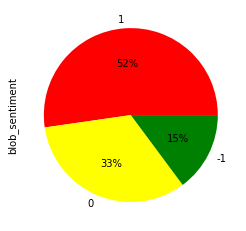

In [ ]:
df_sentiment.blob_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

We can visualize the relationship between both outputs of TextBlob model using a scatter histogram

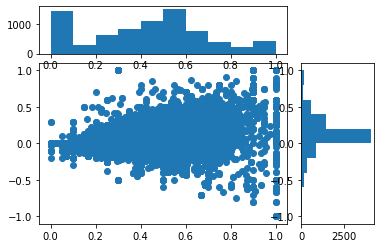

In [ ]:
from matplotlib.gridspec import GridSpec

fig = plt.figure()
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(df_sentiment['blob_subjectivity_continuous'], df_sentiment['blob_sentiment_continuous'])

ax_hist_x.hist(df_sentiment['blob_subjectivity_continuous'])
ax_hist_y.hist(df_sentiment['blob_sentiment_continuous'], orientation = 'horizontal')

plt.show()

**Conparing the 2 models**

One question we can ask ourselves is if both Vader and TextBlob yields the same sentiment prediction. A first idea can be obtained by plotting the distribution of the sentiment analysis output. 

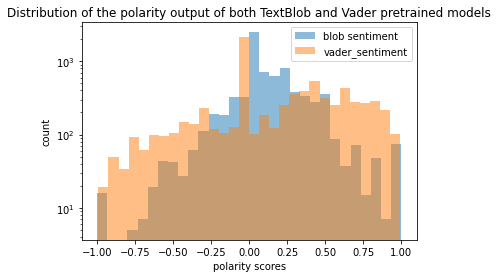

In [ ]:
plt.hist(df_sentiment['blob_sentiment_continuous'], bins=30, alpha=0.5, label='blob sentiment',log=True)
plt.hist(df_sentiment['vader_sentiment_continuous'], bins=30, alpha=0.5, label='vader_sentiment',log=True)
plt.xlabel('polarity scores')
plt.ylabel('count')
plt.legend(loc = 'best')
plt.title('Distribution of the polarity output of both TextBlob and Vader pretrained models')
plt.show()

We can also calculate the mean and the standard error fo the mean of the scores of both model :

In [ ]:
mean_blob = df_sentiment.blob_sentiment_continuous.mean()
mean_vader = df_sentiment.vader_sentiment_continuous.mean()

In [ ]:
print(f'The mean of the score of the blob model is : {mean_blob}')
print(f'The mean of the score of vader model is : {mean_vader}')


The mean of the score of the blob model is : 0.11493740299788917
The mean of the score of vader model is : 0.18905982839313526


To determine if the difference in means between the two models is statistically significant, we perform a ttest. The null hypothesis is that the means of both models are equal whereas the alternative hypothesis is that their means are different. 

In [ ]:
ttest_ind(df_sentiment['blob_sentiment_continuous'], df_sentiment['vader_sentiment_continuous'])

Ttest_indResult(statistic=-13.399269579176066, pvalue=1.0328837041591939e-40)

As we can see from the t-test result, the p-value is really small (p < 0.05). We can thus reject the null hypotesis (equal means) and confirm that the difference in means between the two models is statistically significant.

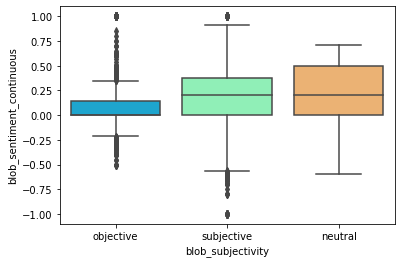

In [ ]:
sns.boxplot(x='blob_subjectivity',y='blob_sentiment_continuous',data=df_sentiment, palette='rainbow')


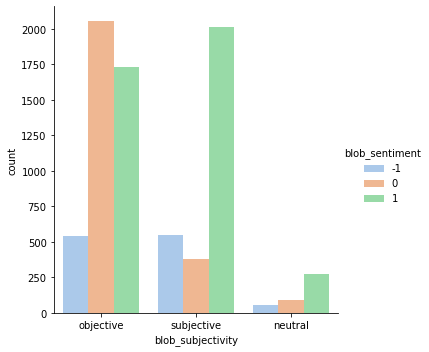

In [ ]:
sns.catplot(x="blob_subjectivity", kind="count", palette="pastel", data=df_sentiment, hue='blob_sentiment')

We prepare a new dataframe that will contain the output of both models and the stock market returns for the next step that is a linear regression. Because for a specific day, we can have several quotes, we need to aggregate the scores obtained for each quote by using the mean of the scores. To do so, we group by date `df_sentiment` and calculate the mean of the continuous variables in each column for each group. Now that we have one score value per day for each model, we can concatenate this dataframe with `df_returns` obtained previously, and we obtain the dataframe `result` in which we have one date per row, with the output of both models and the stock return corresponding to this day. 

In our analyses, we make the hypothesis that the influence that Elon Musk can have on Tesla stock price can be seen the same day.

In [ ]:
grouped_by_date_df = df_sentiment.groupby('just_date',as_index=False).mean() #we aggregate all the quotations which were said on this day 
grouped_by_date_df['just_date']= pd.to_datetime(grouped_by_date_df.just_date) 
grouped_by_date_df.head()

,just_date,vader_sentiment,vader_sentiment_continuous,blob_sentiment,blob_sentiment_continuous,blob_subjectivity_continuous
0,2015-01-06,0.200000,0.276160,0.000000,0.083333,0.310000
1,2015-01-07,1.000000,0.648600,-1.000000,-0.141667,0.458333
2,2015-01-12,-0.333333,-0.355200,0.000000,-0.037063,0.766270
3,2015-01-13,0.500000,0.203250,0.071429,0.040945,0.408545
4,2015-01-14,0.113636,0.097884,0.159091,0.092408,0.340543


We set the date as new indexes of both dataframes `grouped_by_date_df` and `result` to be able to concatenate them into a new common dataframe

In [ ]:
grouped_by_date_df = grouped_by_date_df.set_index('just_date')
df_returns = df_returns.set_index('just_date')
result = pd.concat([grouped_by_date_df, df_returns], axis=1)
result

,vader_sentiment,vader_sentiment_continuous,blob_sentiment,blob_sentiment_continuous,blob_subjectivity_continuous,returns
just_date,,,,,,
2015-01-05,NaN,NaN,NaN,NaN,NaN,-0.042041
2015-01-06,0.200000,0.276160,0.0,0.083333,0.310000,0.005664
2015-01-07,1.000000,0.648600,-1.0,-0.141667,0.458333,-0.001562
2015-01-08,NaN,NaN,NaN,NaN,NaN,-0.001564
2015-01-09,NaN,NaN,NaN,NaN,NaN,-0.018802
...,...,...,...,...,...,...
2020-04-10,1.000000,0.318200,0.0,0.000000,1.000000,NaN
2020-04-13,NaN,NaN,NaN,NaN,NaN,0.136038
2020-04-14,1.000000,0.318200,0.0,0.037500,0.312500,0.090545


We have many NaN values in this dataframe. The first reason is that we can have some days in which no quotes were said. We decided to fill the values with the score of the day before, because this quote will be the last thinf Elon Musk said and according to our hypothesis represent a factor that can play a role in the evolution of the stock price. The other reason is because there are no returns on weekends or on holidays. So the weekend quotes and their corresponding scores are aggregated with mondays quotes because we can only assess their effect on monday's stock price.

In [ ]:
#there are some day where no quotation have been said so we fix this by replicating what was said on the day before 
result.vader_sentiment_continuous.fillna(method='ffill',inplace = True)
result.blob_sentiment_continuous.fillna(method='ffill',inplace = True)
result.blob_subjectivity_continuous.fillna(method='ffill',inplace = True)


Il ya des jours ou aucune quotation n'existe pour résoudre cela on a décider de remplir avec ce qui a était dit le jour précedent, on suppose que la quotation qui a était dit aujourd'hui peut avoir une influence sur le return de demain. 

Pour le lundi on veut prendre en compte tout ce qui a était dit pendant le weekend donc on cherche a aggregate. 
Il faut d'abord commencer à trouvrer les weekends les selectionner et leur donnner comme setiment l'aggregation des 2 jours précedents ensuite on peut les drops psk on aura plus besoin vu ils auront pas de return. 

I think we should also drop the first row



Using the function weekday, we can know to which day corresponds a specific date and thus spot the weekends. We then computed the function fixReturns. Three possibilities are possible : we have the complete weekend, or we can have only quotes on Saturday or Sunday, or finally no quotes were said during the weekend. For each of these conditions, we aggregare the data using the mean of the scor for the days we have.

In [ ]:
result.reset_index(inplace = True) 
result['weekday'] = result['just_date'].apply(lambda x: x.weekday())
result

,just_date,vader_sentiment,vader_sentiment_continuous,blob_sentiment,blob_sentiment_continuous,blob_subjectivity_continuous,returns,weekday
0,2015-01-05,NaN,NaN,NaN,NaN,NaN,-0.042041,0
1,2015-01-06,0.200000,0.276160,0.0,0.083333,0.310000,0.005664,1
2,2015-01-07,1.000000,0.648600,-1.0,-0.141667,0.458333,-0.001562,2
3,2015-01-08,NaN,0.648600,NaN,-0.141667,0.458333,-0.001564,3
4,2015-01-09,NaN,0.648600,NaN,-0.141667,0.458333,-0.018802,4
...,...,...,...,...,...,...,...,...
1656,2020-04-10,1.000000,0.318200,0.0,0.000000,1.000000,NaN,4
1657,2020-04-13,NaN,0.318200,NaN,0.000000,1.000000,0.136038,0
1658,2020-04-14,1.000000,0.318200,0.0,0.037500,0.312500,0.090545,1
1659,2020-04-15,0.000000,0.341750,1.0,0.288988,0.409524,0.028089,2


In [ ]:
 def fixReturns(row): 

  indexFirstAnt = row.name - 1 
  indexSecondAnt = row.name - 2 

  onlySaturday = False 
  onlySunday = False 
  weekend  = False

  if indexFirstAnt >= 0:
    onlySaturday = ((row['weekday'] == 0) & (result.iloc[indexFirstAnt,5] == 5)) #only saturday stock the value of indexFirstAnt
  if indexSecondAnt >= 0 & indexFirstAnt >= 0:
    onlySunday = (((row['weekday'] == 0)  & (result.iloc[indexFirstAnt,5] == 6)) & (result.iloc[indexSecondAnt,5] != 5)) #only sunday stock the value of indexFirstAnt
    weekend = (((row['weekday'] == 0)  & (result.iloc[indexFirstAnt,5] == 6)) & (result.iloc[indexSecondAnt,5] == 5)) #all the weekend aggregate 
    
  if weekend:
    agg_vader = (result.iloc[indexFirstAnt, 1] + result.iloc[indexSecondAnt, 1] + row.vader_sentiment_continuous)/3  #vader_sentiment_continuous
    agg_blob_sent = (result.iloc[indexFirstAnt, 2] + result.iloc[indexSecondAnt, 2] + row.blob_sentiment_continuous)/3 #blob_sentiment_continuous
    agg_blob_subj = (result.iloc[indexFirstAnt, 3] + result.iloc[indexSecondAnt, 3] + row.blob_subjectivity_continuous)/3 #blob_subjectivity_continuous
    return (agg_vader, agg_blob_sent,agg_blob_subj)
  elif onlySaturday | onlySunday: 
    agg_vader = (result.iloc[indexFirstAnt, 1] + row.vader_sentiment_continuous)/2
    agg_blob_sent = (result.iloc[indexFirstAnt, 2] + row.blob_sentiment_continuous)/2
    agg_blob_subj = (result.iloc[indexFirstAnt, 3] + row.blob_subjectivity_continuous)/2
    return (agg_vader, agg_blob_sent,agg_blob_subj)
  else:   #no weekend do nothing
    return (row.vader_sentiment_continuous, row.blob_sentiment_continuous,row.blob_subjectivity_continuous)
def example(x): 
  return x.name - 1 

df= result.apply(lambda x: fixReturns(x), axis=1)


In [ ]:
#save the values back in the dataframe 
columns = ("vader_sentiment_continuous blob_sentiment_continuous blob_subjectivity_continuous" ).split()
result.iloc[:,1:4] = pd.DataFrame([[a, b, c] for a,b,c in df.values], columns=columns)

Now that we have replicated the values of the sentiment analysis during the weekends we can safely drop the rows where we have a null return. 

In [ ]:
result.dropna(inplace = True)

In [ ]:
result

,just_date,vader_sentiment,vader_sentiment_continuous,blob_sentiment,blob_sentiment_continuous,blob_subjectivity_continuous,returns,weekday
1,2015-01-06,0.276160,0.083333,0.310000,0.083333,0.310000,0.005664,1
2,2015-01-07,0.648600,-0.141667,0.458333,-0.141667,0.458333,-0.001562,2
3,2015-01-08,0.648600,-0.141667,0.458333,-0.141667,0.458333,-0.001564,3
4,2015-01-09,0.648600,-0.141667,0.458333,-0.141667,0.458333,-0.018802,4
5,2015-01-12,-0.355200,-0.037063,0.766270,-0.037063,0.766270,-0.021533,0
...,...,...,...,...,...,...,...,...
1655,2020-04-09,0.599400,0.158333,0.302381,0.158333,0.302381,0.044020,3
1657,2020-04-13,0.318200,0.000000,1.000000,0.000000,1.000000,0.136038,0
1658,2020-04-14,0.318200,0.037500,0.312500,0.037500,0.312500,0.090545,1
1659,2020-04-15,0.341750,0.288988,0.409524,0.288988,0.409524,0.028089,2


In [ ]:
import statsmodels.formula.api as smf


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
mod = smf.ols(formula='returns ~ vader_sentiment_continuous + blob_sentiment_continuous + blob_subjectivity_continuous + weekday', data=result)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.026
Date:                Fri, 17 Dec 2021   Prob (F-statistic):             0.0286
Time:                        15:09:44   Log-Likelihood:                 2674.4
No. Observations:                1329   AIC:                            -5341.
Df Residuals:                    1325   BIC:                            -5320.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [ ]:
correlation1 = result['returns'].corr(result['vader_sentiment_continuous'])
correlation2 = result['returns'].corr(result['blob_sentiment_continuous'])
correlation3 = result['returns'].corr(result['blob_subjectivity_continuous'])
print('df_tesla')
print( correlation1, correlation2, correlation3 )


df_tesla
0.020305960862902966 0.020305960862902966 -0.003495821880736184


## **Figures for the dataStory:**

### ***1. Plot quotations per day for every year***

First Tesla crush in June 2016, notice the increase of the number of quotes during this period  

In [ ]:
pip install -U plotly

     |████████████████████████████████| 25.3 MB 1.5 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
import plotly.express as px


In [ ]:
import plotly.graph_objects as go
quotesperday= df_tesla.groupby(by='just_date').size().reset_index(name='Number of quotes')
xq = quotesperday.just_date
yq = quotesperday['Number of quotes']
#quotesperday.year = quotesperday.apply()
#fig = go.Figure(data=go.Bar(x= xq , y= yq))
fig0 = px.line(quotesperday, x='just_date', y='Number of quotes',range_x=['2015-06-01','2015-12-31'],markers=True )
fig1 = px.line(quotesperday, x='just_date', y='Number of quotes', range_x=['2016-01-01','2016-12-31'])
fig2 = px.line(quotesperday, x='just_date', y='Number of quotes', range_x=['2017-01-01','2017-12-31'])
fig3 = px.line(quotesperday, x='just_date', y='Number of quotes', range_x=['2018-01-01','2018-12-31'])
fig4 = px.line(quotesperday, x='just_date', y='Number of quotes', range_x=['2019-01-01','2019-12-31'])
fig5 = px.line(quotesperday, x='just_date', y='Number of quotes', range_x=['2020-01-01','2020-04-16'])


fig0.show()
fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()


In [ ]:
quotesperday['year']= quotesperday['just_date'].apply(lambda x: x.year)
fig0 = px.line(quotesperday, x='just_date', y='Number of quotes',markers=True, color = 'year' )
fig0.show()

### ***2. Compare between 2 sentiment analysis models***

In [ ]:
import plotly

pd.options.plotting.backend = "plotly"

result[['vader_sentiment_continuous','blob_sentiment_continuous']].plot(
    kind='hist',
    bins=50,
    title='Vader vs Blob Sentiment Polarity Distribution')

In [ ]:
px.scatter(result, y = 'returns', x = 'vader_sentiment_continuous', title = 'Correlation between sentiment and the returns')

In [ ]:

fig0= px.line(result, x='just_date', y='returns',range_x=['2016-01-01','2016-12-31'],markers=True )
import os
linkhtml= plotly.io.to_html(fig0)
f = open("/content/drive/MyDrive/returns.txt",'w')
f.write(linkhtml)
f.close()
fig0.show()


# **June 2016 quotations:**
We can notice from the plots that on June 22 there was a drastic decrease in tesla's share price, lets understand where does this comes from. 
In order to analyse what happened on june 2016 we decided to inspect the quotations said during this month. 

In [ ]:
start_date = pd.to_datetime("2016-06-01").date()
end_date = pd.to_datetime("2016-06-30").date()
df_june = df_tesla[(df_tesla['just_date'] >= start_date)& (df_tesla['just_date'] <=  end_date)]
sfmt = 'The {just_date} Elon Musk said: {quotation} '.format
test = df_june.apply(lambda x: sfmt(**x), 1)
for quote in test:
  print(quote)

The 2016-06-30 Elon Musk said: one of the safest cars on the road, 
The 2016-06-22 Elon Musk said: Instead of making three trips to a house to put in a car charger and solar panels and battery pack, you can integrate that into a single visit, 
The 2016-06-29 Elon Musk said: we need sustainable energy production, which is going to come primarily in the form of solar, overwhelmingly in the form of solar in my view and combine that with stationary storage and electric vehicle, and you have a complete solution to a sustainable energy future. 
The 2016-06-30 Elon Musk said: friend to Tesla and the broader EV community, a person who spent his life focused on innovation and the promise of technology and who believed strongly in Tesla's mission. 
The 2016-06-01 Elon Musk said: One thing Tesla is good at is we throw good parties, 
The 2016-06-30 Elon Musk said: And when we look at the data -- this is a really interesting fact -- of cars that if Autopilot is turned on or off, 
The 2016-06-30 Elo

In [ ]:
df_june 

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,just_date,selected_quotes,removed_punctuation,casefold,tokenize_quote,remove_sw,lemmatized_quote
33935,2016-06-30-019259,"one of the safest cars on the road,",Elon Musk,[Q317521],2016-06-30 21:15:36,6,"[[Elon Musk, 0.7402], [None, 0.2598]]",[http://ca.finance.yahoo.com/news/tesla-report...,E,2016-06-30,True,one of the safest cars on the road,one of the safest cars on the road,"[one, of, the, safest, cars, on, the, road]","[one, safest, cars, road]","[one, safest, car, road]"
34477,2016-06-22-001022,Instead of making three trips to a house to pu...,Elon Musk,[Q317521],2016-06-22 16:04:58,9,"[[Elon Musk, 0.7808], [None, 0.2162], [Peter R...",[http://hauteliving.com/2016/06/elon-musk-is-g...,E,2016-06-22,True,Instead of making three trips to a house to pu...,instead of making three trips to a house to pu...,"[instead, of, making, three, trips, to, a, hou...","[instead, making, three, trips, house, put, ca...","[instead, making, three, trip, house, put, car..."
34561,2016-06-29-010077,"we need sustainable energy production, which i...",Elon Musk,[Q317521],2016-06-29 15:16:38,1,"[[Elon Musk, 0.9258], [None, 0.0742]]",[http://seekingalpha.com/article/3985216-will-...,E,2016-06-29,True,we need sustainable energy production which is...,we need sustainable energy production which is...,"[we, need, sustainable, energy, production, wh...","[need, sustainable, energy, production, going,...","[need, sustainable, energy, production, going,..."
34806,2016-06-30-005933,"friend to Tesla and the broader EV community, ...",Elon Musk,[Q317521],2016-06-30 21:28:22,28,"[[Elon Musk, 0.4786], [None, 0.34], [Joshua Br...",[http://q13fox.com/2016/06/30/tesla-confirms-f...,E,2016-06-30,True,friend to Tesla and the broader EV community a...,friend to tesla and the broader ev community a...,"[friend, to, tesla, and, the, broader, ev, com...","[friend, tesla, broader, ev, community, person...","[friend, tesla, broader, ev, community, person..."
35067,2016-06-01-001368,One thing Tesla is good at is we throw good pa...,Elon Musk,[Q317521],2016-06-01 13:17:39,3,"[[Elon Musk, 0.8784], [None, 0.1216]]",[http://driving.ca/tesla/auto-news/news/tesla-...,E,2016-06-01,True,One thing Tesla is good at is we throw good pa...,one thing tesla is good at is we throw good pa...,"[one, thing, tesla, is, good, at, is, we, thro...","[one, thing, tesla, good, throw, good, parties]","[one, thing, tesla, good, throw, good, party]"
35612,2016-06-30-001684,And when we look at the data -- this is a real...,Elon Musk,[Q317521],2016-06-30 22:55:00,2,"[[Elon Musk, 0.9633], [None, 0.0367]]",[http://www.fool.com/investing/2016/06/30/tesl...,E,2016-06-30,True,And when we look at the data this is a really...,and when we look at the data this is a really...,"[and, when, we, look, at, the, data, this, is,...","[look, data, really, interesting, fact, cars, ...","[look, data, really, interesting, fact, car, a..."
36254,2016-06-30-001946,As a combined automotive and power storage and...,Elon Musk,[Q317521],2016-06-30 17:36:54,1,"[[Elon Musk, 0.9099], [None, 0.0901]]",[http://seekingalpha.com/article/3985543-tesla...,E,2016-06-30,True,As a combined automotive and power storage and...,as a combined automotive and power storage and...,"[as, a, combined, automotive, and, power, stor...","[combined, automotive, power, storage, power, ...","[combined, automotive, power, storage, power, ..."
36261,2016-06-01-001673,The best thing to do is to charge your car whe...,Elon Musk,[Q317521],2016-06-01 13:17:39,1,"[[Elon Musk, 0.8519], [None, 0.1481]]",[http://driving.ca/tesla/auto-news/news/tesla-...,E,2016-06-01,True,The best thing to do is to charge your car whe...,the best thing to do is to charge your car whe...,"[the, best, thing, to, do, is, to, charge, you...","[best, thing, charge, car, charge, phone, home...","[best, thing, charge, car, charge, phone, home..."
38140,2016-06-21-001608,This would start with the car you drive and t

In [ ]:
start_date = pd.to_datetime("2018-09-27").date()
end_date = pd.to_datetime("2018-10-04").date()
df_june = df_tesla[(df_tesla['just_date'] >= start_date)& (df_tesla['just_date'] <=  end_date)]
sfmt = 'The {just_date} Elon Musk said: {quotation} '.format
test = df_june.apply(lambda x: sfmt(**x), 1)
for quote in test:
  print(quote)

The 2018-09-27 Elon Musk said: [ s ] ubjects Tesla to constant defamatory attacks by the short-selling community, resulting in great harm to our valuable brand. 
The 2018-09-27 Elon Musk said: Offer to Take Tesla Private at $420. 
The 2018-10-01 Elon Musk said: drive Tesla into bankruptcy even faster. 
The 2018-09-30 Elon Musk said: On August 7, 2018, Musk tweeted to his 22 million Twitter followers that he could take Tesla private at $420 per share (a substantial premium to its trading price at the time), that funding for the transaction had been secured, and that the only remaining uncertainty was a shareholder vote. The SEC's complaint alleges that, in truth, Musk had not discussed specific deal terms with any potential financing partners, and he allegedly knew that the potential transaction was uncertain and subject to numerous contingencies. According to the SEC's complaint, Musk's tweets caused Tesla's stock price to jump by over six percent on August 7, and led to significant ma